In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import silhouette_score, calinski_harabaz_score 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_pickle('customer_numerical_standardized.pkl')
df.head(5)

,Freq,Age,Large_Hospital,Medium_Hospital,Payer_Out_of_Pocket,Payer_Special_Program,Payer_State,region_Porto,region_Santarem,region_Viseu,General_Service_Emergency,General_Service_Examination,General_Service_Others,General_Service_Surgery,General_Service_Treatment,Sex_Masculino,Sex_Missing
0,-0.279657,0.297376,0.171623,-0.555808,-0.493714,-0.189121,-0.538143,1.852339,-0.221605,-0.164676,0.563824,0.583638,-0.134845,-0.336768,-0.384018,1.116113,-0.055554
1,0.023680,1.016946,1.036258,-0.555808,-0.493714,-0.189121,-0.028397,-0.543157,-0.221605,-0.164676,-0.436760,0.898848,-0.134845,-0.336768,-0.384018,-0.895966,-0.055554
2,-0.507160,-1.343594,-1.125331,-0.555808,-0.493714,-0.189121,-0.538143,1.852339,-0.221605,-0.164676,-0.436760,0.268427,-0.134845,-0.336768,-0.384018,-0.895966,-0.055554
3,-0.431325,-0.158936,-1.125331,1.974664,-0.493714,-0.189121,-0.538143,-0.543157,-0.221605,-0.164676,-0.436760,1.056454,-0.134845,1.815089,-0.384018,1.116113,-0.055554
4,-0.431325,-1.277779,1.036258,-0.555808,-0.493714,-0.189121,0.736222,-0.543157,-0.221605,-0.164676,4.566161,-1.307628,-0.134845,-0.336768,-0.384018,1.116113,-0.055554


In [5]:
df.shape

(1468101, 17)

## Choose the number of k using the elbow method

In [4]:
from scipy.spatial.distance import cdist

In [5]:
# compute total variance
total_variance = cdist(
    XA=df, 
    XB=np.array([df.mean()])
)
total_variance_sum = total_variance.sum()

In [6]:
# function that returns in the variance in each cluster
def cluster_variance(cluster_id, cluster_centroid, cluster_labels):
    cluster_elements = df[cluster_labels==cluster_id]
    return cdist(XA=cluster_elements, XB=np.array([cluster_centroid])).sum()

# function that returns the percentage of variance explained for a kmeans model
def variance_measure(estimator_kmeans, total_variance):
    clusters_labels = estimator_kmeans.labels_
    wss = 0
    for i, cluster_id in enumerate(np.unique(clusters_labels)):
        cluster_centroid = estimator_kmeans.cluster_centers_[i]
        wss += cluster_variance(cluster_id, cluster_centroid, clusters_labels)
    return (total_variance-wss) / total_variance 

In [7]:
# function that returns the inertia of a kmeans model
def inertia_measure(estimator_kmeans):
    return estimator_kmeans.inertia_

In [8]:
# function that returns either score for a kmeans model with a certain k
def evaluate_k_kmeans(k, scoring, **kwargs):
    scoring_measure = None
    if scoring=="inertia":
        scoring_measure = inertia_measure
    elif scoring=="variance":
        scoring_measure = variance_measure
        
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(df)
    return scoring_measure(estimator_kmeans, **kwargs)

In [10]:
# compute the inertia and variance explained for kmeans models with different k
results_k = {}
range_k = [5, 10, 20, 30, 50, 100, 150]
for k in range_k:
    results_k[k] = (
        evaluate_k_kmeans(k, "inertia"), 
        evaluate_k_kmeans(k, "variance", total_variance=total_variance_sum), 
    )
    print (results_k)

{5: (18677172.654480863, 0.13603752113929873)}
{5: (18677172.654480863, 0.13603752113929873), 10: (12964980.178911855, 0.2549049771253201)}
{5: (18677172.654480863, 0.13603752113929873), 10: (12964980.178911855, 0.2549049771253201), 20: (8760379.375601145, 0.3871662042563958)}
{5: (18677172.654480863, 0.13603752113929873), 10: (12964980.178911855, 0.2549049771253201), 20: (8760379.375601145, 0.3871662042563958), 30: (7523865.696871291, 0.4353859209044843)}
{5: (18677172.654480863, 0.13603752113929873), 10: (12964980.178911855, 0.2549049771253201), 20: (8760379.375601145, 0.3871662042563958), 30: (7523865.696871291, 0.4353859209044843), 50: (6184039.159198216, 0.4951655887003782)}
{5: (18677172.654480863, 0.13603752113929873), 10: (12964980.178911855, 0.2549049771253201), 20: (8760379.375601145, 0.3871662042563958), 30: (7523865.696871291, 0.4353859209044843), 50: (6184039.159198216, 0.4951655887003782), 100: (4481053.619555949, 0.5777416786146036)}
{5: (18677172.654480863, 0.1360375211

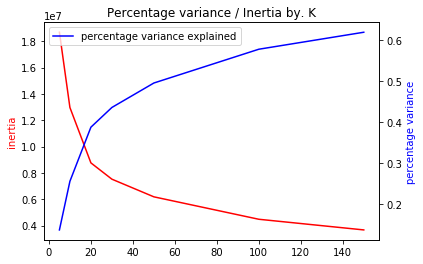

In [11]:
fig, ax1 = plt.subplots()

ax1.plot(
    [c[0] for c in results_k.items()],
    [c[1][0] for c in results_k.items()], label="inertia", color="red")
ax1.set_ylabel('inertia', color="red")


ax2 = ax1.twinx()
ax2.plot(
    [c[0] for c in results_k.items()],
    [c[1][1] for c in results_k.items()], label="percentage variance explained", color="blue")
ax2.set_ylabel('percentage variance', color='blue')

plt.xlabel("K")
plt.legend()
plt.title("Percentage variance / Inertia by. K");

## K-means with 30 clusters

In [12]:
estimator_kmeans = KMeans(random_state=42, n_clusters=30)

estimator_kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=30, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [13]:
labels = pd.DataFrame(estimator_kmeans.predict(df))

In [14]:
labels[0].value_counts()

2     136102
25    101816
9      92886
4      80263
19     72892
13     69729
28     68816
14     64583
3      63792
29     63306
5      63061
21     57446
20     53875
12     47041
10     46050
1      45940
0      42756
18     40990
23     38288
7      37624
26     33388
8      32077
27     28134
17     20460
24     18623
22     18271
11     16799
16      4567
6       4514
15      4012
Name: 0, dtype: int64

In [15]:
centroids = estimator_kmeans.cluster_centers_
centroids

array([[-3.39094401e-01,  5.03727292e-01,  5.41346370e-01,
        -5.37894960e-01,  2.22290185e+00, -1.82035396e-01,
        -5.10075569e-01, -7.73571516e-02, -2.18904230e-01,
        -1.62904550e-01, -5.44094994e-02,  9.73522525e-01,
        -1.00736564e-01, -2.63976049e-01, -6.58005950e-02,
        -4.46366029e-02, -5.55541131e-02],
       [-1.14675837e-01, -1.04083814e+00,  8.52759696e-01,
        -4.93913432e-01, -3.50933425e-01, -1.77396667e-01,
        -3.37430406e-01, -5.36141719e-01, -2.11097702e-01,
        -1.60646902e-01,  1.69548553e+00, -2.03289277e-01,
        -1.33567686e-01, -2.82090659e-01, -2.36246916e-01,
         1.94766244e-01, -5.55541131e-02],
       [ 3.29663561e-02, -8.61248692e-02,  9.16235612e-01,
        -5.29300502e-01, -4.28027775e-01, -1.80802554e-01,
        -4.91683821e-01, -5.40390603e-01, -2.15364943e-01,
        -1.63740281e-01, -2.26732506e-01,  2.00691365e-01,
        -6.69304518e-02, -1.66115361e-01, -2.10957107e-01,
        -8.95966250e-01, -5.5

In [16]:
centroids.shape

(30, 17)

In [17]:
estimator_kmeans.inertia_

7523865.696871291

In [20]:
sklearn.metrics.silhouette_score(df,labels[0].ravel())

0.20172863887134618

## K-means with 10 clusters

In [21]:
estimator_kmeans2 = KMeans(random_state=42, n_clusters=10)

estimator_kmeans2.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [22]:
labels2 = pd.DataFrame(estimator_kmeans2.predict(df))

In [23]:
labels2[0].value_counts()

3    590102
2    222571
5    196792
1    174560
0    118113
4     64528
8     47365
6     37670
9     11883
7      4517
Name: 0, dtype: int64

In [24]:
centroids2 = estimator_kmeans2.cluster_centers_
centroids2

array([[ 1.08004559e+00,  2.87723333e-01,  3.12262057e-01,
        -2.96722728e-01, -2.28396371e-01, -1.81760260e-01,
        -1.24519110e-01,  2.23896494e-01, -2.16495848e-01,
        -1.61937430e-01, -3.29877323e-01, -5.54875264e-01,
        -7.14147305e-02,  2.24126345e+00,  1.63291772e+00,
         9.89139130e-02, -5.55541131e-02],
       [-3.64580963e-01,  1.37267369e-01,  1.86605946e-01,
        -5.35192003e-01,  2.19318660e+00, -1.83457461e-01,
        -5.07319979e-01,  4.84996417e-01, -2.19365859e-01,
        -1.62461675e-01, -6.78319314e-02, -5.02232970e-01,
        -1.08822666e-01, -2.40592033e-01, -2.04103232e-01,
         2.13748260e-03, -5.55541131e-02],
       [-8.46598066e-02,  3.15654002e-01,  1.12812029e-01,
        -4.90209260e-01, -4.17767760e-01, -1.87635949e-01,
         1.87662752e+00,  2.59718973e-01, -2.17239270e-01,
        -1.59430570e-01, -1.74397226e-01,  4.27949084e-01,
        -8.00714775e-02, -2.25457569e-01, -1.82336907e-01,
        -2.02402235e-01, -5.5

In [25]:
estimator_kmeans2.inertia_

12964980.178911855

In [26]:
sklearn.metrics.silhouette_score(df,labels2[0].ravel())

0.18468226930931872

## K-means with 8 clusters

In [7]:
estimator_kmeans3 = KMeans(random_state=42, n_clusters=8)

estimator_kmeans3.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [8]:
labels3 = pd.DataFrame(estimator_kmeans3.predict(df))

In [9]:
labels3[0].value_counts()

4    440487
6    338490
1    319847
0    214406
2     64750
5     47743
7     37861
3      4517
Name: 0, dtype: int64

In [ ]:
sklearn.metrics.silhouette_score(df,labels3[0].ravel())
# accidentally cleared all outputs and didn't have time to run this cell again
# result = 0.138

## summarize the clusters

In [10]:
allvar = pd.read_pickle('allvariables.pkl')
allvar.head()

,Freq,Sex,Age,Age_Group,Hospital,HType,HRegion,Payer,Insurance_Type,Specific_Service,...,General_Service_Treatment,Sex_Feminino,Sex_Masculino,Sex_Missing,Child,Early Working,Elderly,Mature Working,Prime Working,clusterID
UniqueID,,,,,,,,,,,,,,,,,,,,,
00000f7264c27ba6fea0c837ed6aa0aa,4,Masculino,47.4,Prime Working,HCP,Large,Porto,MÉDIS,Private,PATOLOGIA CLINICA,...,0.0,0,1,0,0,0,0,0,1,4
00001e984eba85527fd3122056451279,8,Feminino,63.8,Mature Working,HCIS,Large,Lisbon,ALLIANZ,Private,SERVIÇOS ESPECIAIS DERMATOLOGIA,...,0.0,1,0,0,0,0,0,1,0,7
0000219e4b37d2504fb6b8c28e24a2d4,1,Feminino,10.0,Child,ICDT,Clinic,Porto,MÉDIS,Private,SERVIÇOS ESPECIAIS OFTALMOLOGIA,...,0.0,1,0,0,1,0,0,0,0,6
000026c67a83fa72aec14512887bb173,2,Masculino,37.0,Prime Working,CCC,Medium,Lisbon,MÉDIS,Private,SERVIÇOS ESPECIAIS MEDICINA DENTÁRIA,...,0.0,0,1,0,0,0,0,0,1,3
000028899fe7782862d40bb1b87807ee,2,Masculino,11.5,Child,HCD,Large,Lisbon,ADSE,State,URGÊNCIA PEDIATRIA,...,0.0,0,1,0,1,0,0,0,0,5


In [11]:
# use labels of the model with 8 clusters
allvar.reset_index(inplace=True)
allvar['clusterID'] = labels3[0]
allvar.head()

,UniqueID,Freq,Sex,Age,Age_Group,Hospital,HType,HRegion,Payer,Insurance_Type,...,General_Service_Treatment,Sex_Feminino,Sex_Masculino,Sex_Missing,Child,Early Working,Elderly,Mature Working,Prime Working,clusterID
0,00000f7264c27ba6fea0c837ed6aa0aa,4,Masculino,47.4,Prime Working,HCP,Large,Porto,MÉDIS,Private,...,0.0,0,1,0,0,0,0,0,1,1
1,00001e984eba85527fd3122056451279,8,Feminino,63.8,Mature Working,HCIS,Large,Lisbon,ALLIANZ,Private,...,0.0,1,0,0,0,0,0,1,0,6
2,0000219e4b37d2504fb6b8c28e24a2d4,1,Feminino,10.0,Child,ICDT,Clinic,Porto,MÉDIS,Private,...,0.0,1,0,0,1,0,0,0,0,1
3,000026c67a83fa72aec14512887bb173,2,Masculino,37.0,Prime Working,CCC,Medium,Lisbon,MÉDIS,Private,...,0.0,0,1,0,0,0,0,0,1,0
4,000028899fe7782862d40bb1b87807ee,2,Masculino,11.5,Child,HCD,Large,Lisbon,ADSE,State,...,0.0,0,1,0,1,0,0,0,0,4


In [12]:
allvar.to_pickle('kmean_percentage_allvar.pkl')

In [13]:
categorical_data = allvar.select_dtypes(include = object)
categorical_data.columns.to_list()

['UniqueID',
 'Sex',
 'Age_Group',
 'Hospital',
 'HType',
 'HRegion',
 'Payer',
 'Insurance_Type',
 'Specific_Service',
 'Category_of_Service',
 'General_Service']

In [14]:
def cluster_summary(cluster_id):
    cluster = allvar[allvar.clusterID==cluster_id]
    
    cluster_summary = cluster[categorical_data.columns].mode().to_dict(orient="records")[0]
    cluster_summary.update(cluster.mean().to_dict())
    return cluster_summary

In [15]:
def cluster_comparison(*cluster_ids):
    summaries = []
    for cluster_id in cluster_ids:
        summaries.append(cluster_summary(cluster_id))
    return pd.DataFrame(summaries).set_index("clusterID").T

summary = cluster_comparison(0,1,2,3,4,5,6,7)
summary

clusterID,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
Age,39.9722,39.5495,44.1315,39.4271,32.5754,42.7338,51.1401,44.4377
Age_Group,Prime Working,Prime Working,Prime Working,Prime Working,Prime Working,Prime Working,Prime Working,Prime Working
Category_of_Service,CONSULTA EXTERNA,CONSULTA EXTERNA,CONSULTA EXTERNA,CONSULTA EXTERNA,CONSULTA EXTERNA,CONSULTA EXTERNA,CONSULTA EXTERNA,CONSULTA EXTERNA
Child,0.189164,0.195059,0.111027,0.191277,0.263792,0.165909,0.0320896,0.133092
Clinic,0.0532402,0.360172,0.00389078,0.207695,0.26313,0.273482,0.367683,0.00306735
Early Working,0.0980383,0.0850063,0.087444,0.0816914,0.116026,0.102612,0.0568436,0.088508
Elderly,0.163904,0.160208,0.188355,0.158291,0.0894465,0.226567,0.260584,0.210216
Freq,10.9643,7.01431,5.63492,7.99026,6.04006,7.55095,9.3531,2.7498
General_Service,Examination,Examination,Examination,Examination,Appointment,Examination,Examination,Examination
General_Service_Appointment,0.354647,0.453779,0.430039,0.444362,0.523852,0.394396,0.255776,0.358435


In [16]:
summary.to_pickle('kmean_percentage_summary.pkl')